In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. KHÁM PHÁ CÁC DÒNG VÀ CỘT

In [33]:
df = pd.read_csv("../data/raw/hcmhouseprice_merged.csv")
df.head()

,price,area,bedrooms,bathrooms,address
0,20.6,58.1,1.0,1.0,quận 1
1,20.0,56.0,1.0,1.0,quận 1
2,8.9,51.0,1.0,1.0,quận 1
3,9.5,50.0,1.0,1.0,quận 1
4,10.2,48.0,1.0,1.0,quận 1


In [34]:
display(df.info())
display(df.describe())
display(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2406 entries, 0 to 2405
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      2406 non-null   float64
 1   area       2406 non-null   float64
 2   bedrooms   2406 non-null   float64
 3   bathrooms  2406 non-null   float64
 4   address    2406 non-null   object 
dtypes: float64(4), object(1)
memory usage: 94.1+ KB


None

,price,area,bedrooms,bathrooms
count,2406.000000,2406.000000,2406.000000,2406.000000
mean,9.558039,121.006883,2.827930,2.497506
std,14.185876,1359.995744,3.412632,3.407677
min,0.001000,1.000000,1.000000,0.000000
25%,3.150000,65.000000,2.000000,2.000000
50%,5.400000,75.920000,2.000000,2.000000
75%,10.500000,100.000000,3.000000,2.000000
max,210.000000,66666.000000,60.000000,60.000000


price        0
area         0
bedrooms     0
bathrooms    0
address      0
dtype: int64

Dữ liệu gồm **2,406 dòng** và **không có giá trị khuyết (NaN)**.  
Tuy nhiên, quan sát thống kê mô tả cho thấy có nhiều **giá trị ngoại lệ (outlier)** ở các biến:

- `price` có giá trị cao nhất tới `210` (trong khi Q3 chỉ là `10.5`).  
- `area` có giá trị cực đại `66,666` - khả năng là lỗi cào dữ liệu.  
- `bedrooms` và `bathrooms` có giá trị lên tới `60`, vượt xa thực tế.  

Những giá trị này có thể không phản ánh đúng dữ liệu thực tế, ta sẽ kiểm tra tiếp.

# 2. LÀM SẠCH DỮ LIỆU

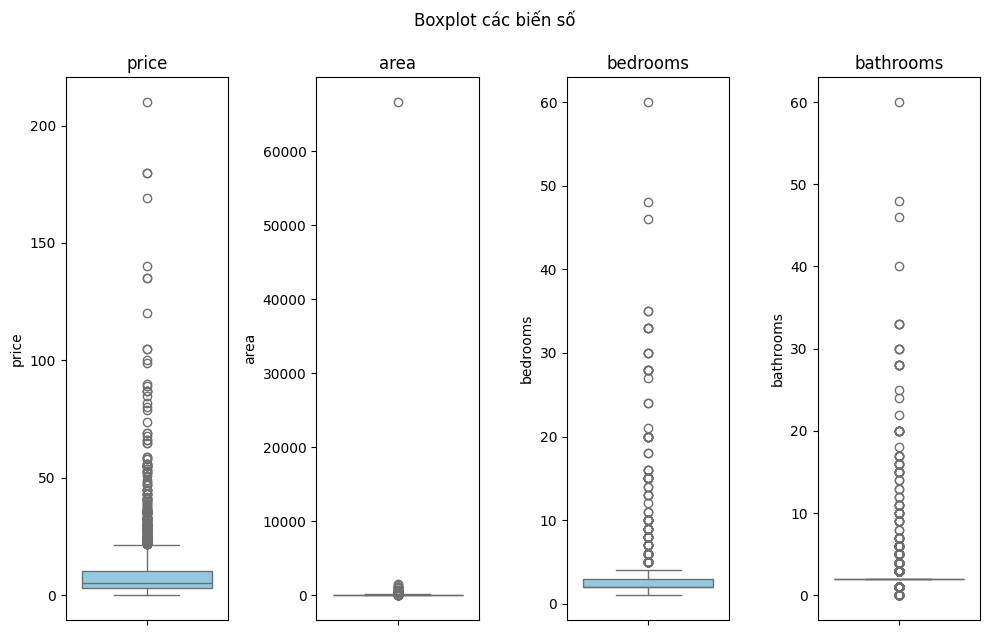

In [35]:
num_cols = ['price', 'area', 'bedrooms', 'bathrooms']

plt.figure(figsize=(10,6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.suptitle("Boxplot các biến số", y=1.05)
plt.show()

Đúng như dự đoán, các **giá trị ngoại lai (outlier)** xuất hiện khá nhiều, vì vậy bắt đầu tiến hành **sàng lọc dữ liệu** để loại bỏ những điểm bất thường.
Tuy nhiên, các outlier vẫn có thể xuất hiện do sự phân bố giá nhà khác nhau giữa các khu vực. 

Do đó, để kiểm tra chi tiết hơn, chúng em sẽ tập trung vào **boxplot của `price`** nhằm quan sát sự phân bố.

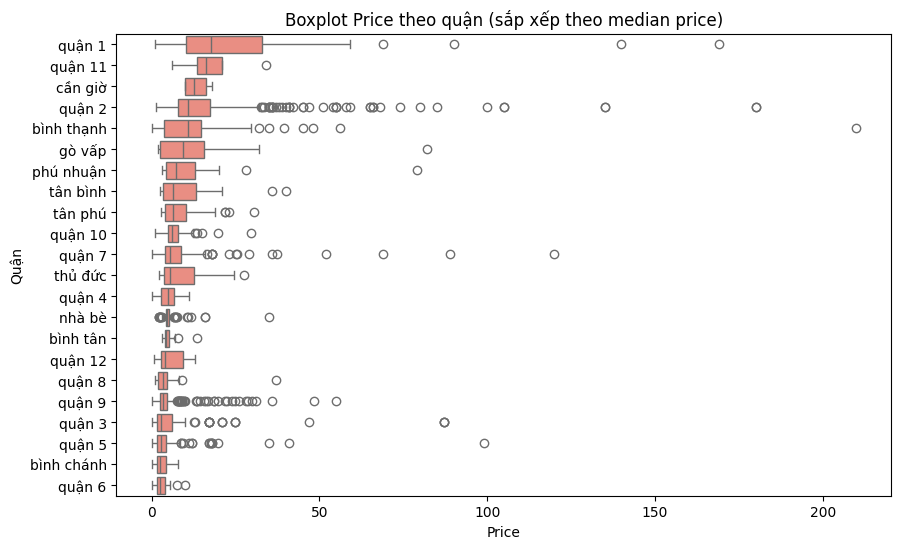

In [36]:
median_by_address = df.groupby('address')['price'].median().sort_values(ascending=False)
sorted_addresses = median_by_address.index.tolist()

plt.figure(figsize=(10,6))
sns.boxplot(
    y='address',
    x='price',
    data=df,
    order=sorted_addresses,
    color='salmon'
)
plt.xlabel("Price")
plt.ylabel("Quận")
plt.title("Boxplot Price theo quận (sắp xếp theo median price)")
plt.show()

Quan sát boxplot và phân bố giá theo quận cho thấy:

- **Outlier xuất hiện tập trung ở một số quận**, không phân bố đều.
- Các quận có sự chênh lệch đáng kể về **median của price, area, bedrooms, bathrooms**.
- Sau khi thử loại bỏ outlier, dữ liệu trở nên mất cân bằng (variance không tự nhiên), đặc biệt ở cột **bathrooms** - hầu hết giá trị còn lại đều là 2.
- Điều này cho thấy việc loại bỏ outlier có thể vô tình loại luôn những mẫu thực tế, vì **giá có thể phụ thuộc vào số phòng ngủ, phòng tắm…**, không phải lúc nào giá cao cũng là bất thường.

**Vì vậy, quyết định giữ lại toàn bộ outlier**, nhằm bảo toàn thông tin thật và tránh bóp méo phân phối dữ liệu.


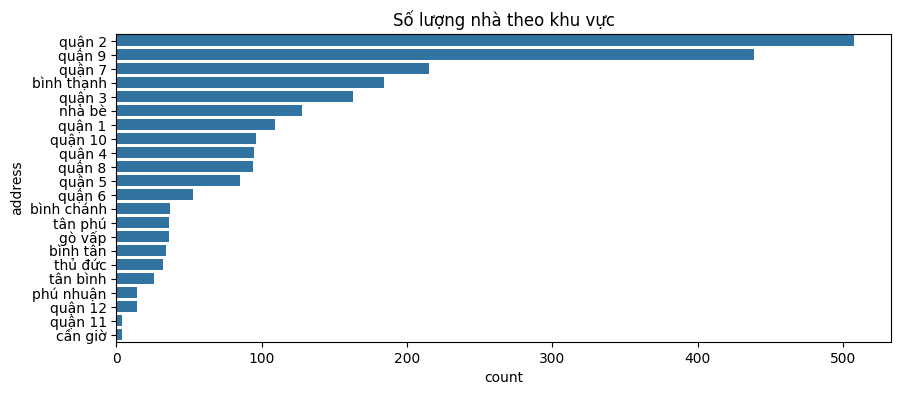

In [37]:
plt.figure(figsize=(10,4))
sns.countplot(y='address', data=df, order=df['address'].value_counts().index)
plt.title("Số lượng nhà theo khu vực")
plt.show()


Quan sát dữ liệu qua **EDA** cho thấy sự phân bố mẫu giữa các quận không đồng đều:  
một số quận như **Cần Giờ, Gò Vấp, Thủ Đức, Tân Bình, Phú Nhuận, Quận 12, Quận 11** chỉ có **số lượng mẫu rất ít**, không đủ đại diện để mô hình học chính xác các mối quan hệ giữa `price`, `area`, `bedrooms` và `bathrooms`.  

Nếu giữ lại các quận này:
- Mô hình có thể **học kém** về các quận đó do thiếu dữ liệu.  
- Ngoại lệ hoặc dữ liệu ít có thể **gây nhiễu**, làm tăng sai số dự đoán.  

Do đó, để **tối ưu chất lượng dự đoán và tránh overfitting trên các quận có ít dữ liệu**, chúng em quyết định **loại bỏ các quận này** và tập trung phân tích trên các quận có **số lượng mẫu đủ lớn** theo tiêu chí `số mẫu < 10`

In [38]:
counts = df['address'].value_counts()

valid_addresses = counts[counts >= 10].index.tolist()

df_filtered = df[df['address'].isin(valid_addresses)].copy()

print("Số mẫu còn lại theo quận (>=10 mẫu):")
display(df_filtered['address'].value_counts())

df = df_filtered.copy()

Số mẫu còn lại theo quận (>=10 mẫu):


address
quận 2        508
quận 9        439
quận 7        215
bình thạnh    184
quận 3        163
nhà bè        128
quận 1        109
quận 10        96
quận 4         95
quận 8         94
quận 5         85
quận 6         53
bình chánh     37
gò vấp         36
tân phú        36
bình tân       34
thủ đức        32
tân bình       26
phú nhuận      14
quận 12        14
Name: count, dtype: int64

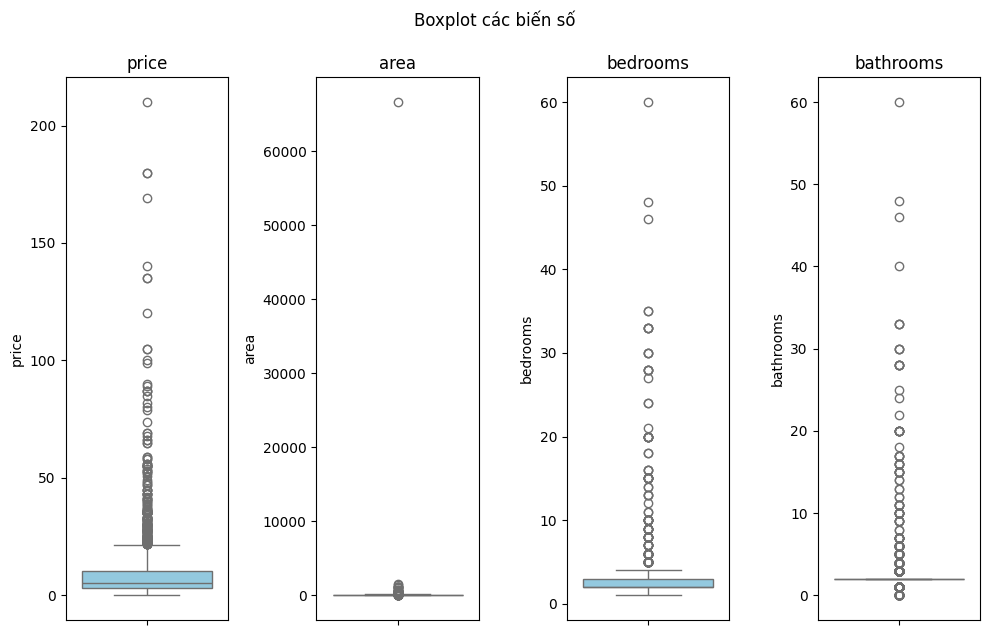

In [39]:
num_cols = ['price', 'area', 'bedrooms', 'bathrooms']

plt.figure(figsize=(10,6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.suptitle("Boxplot các biến số", y=1.05)
plt.show()

Mặc dù các outlier có thể ảnh hưởng tiêu cực đến mô hình, việc **lọc quá mạnh** để loại bỏ mọi điểm bất thường có thể dẫn đến **mất một lượng lớn dữ liệu quan trọng**, đặc biệt là các quận hoặc phân khúc nhà có giá cao, diện tích lớn.

Nếu lọc quá nghiêm ngặt, mô hình sẽ **thiếu dữ liệu để học**, tăng nguy cơ **underfitting** và không phản ánh đúng **phân bố thực tế của thị trường**. Do đó sẽ sử dụng bộ dữ liệu này để tiến hành phân tích và huấn luyện.

# 3. PHÂN TÍCH DỮ LIỆU

,address,median_price_per_m2
0,quận 1,0.192308
1,tân bình,0.125776
2,gò vấp,0.118625
3,quận 2,0.117223
4,bình thạnh,0.111545
5,phú nhuận,0.090857
6,tân phú,0.075091
7,quận 7,0.075000
8,quận 10,0.073875
9,thủ đức,0.067083


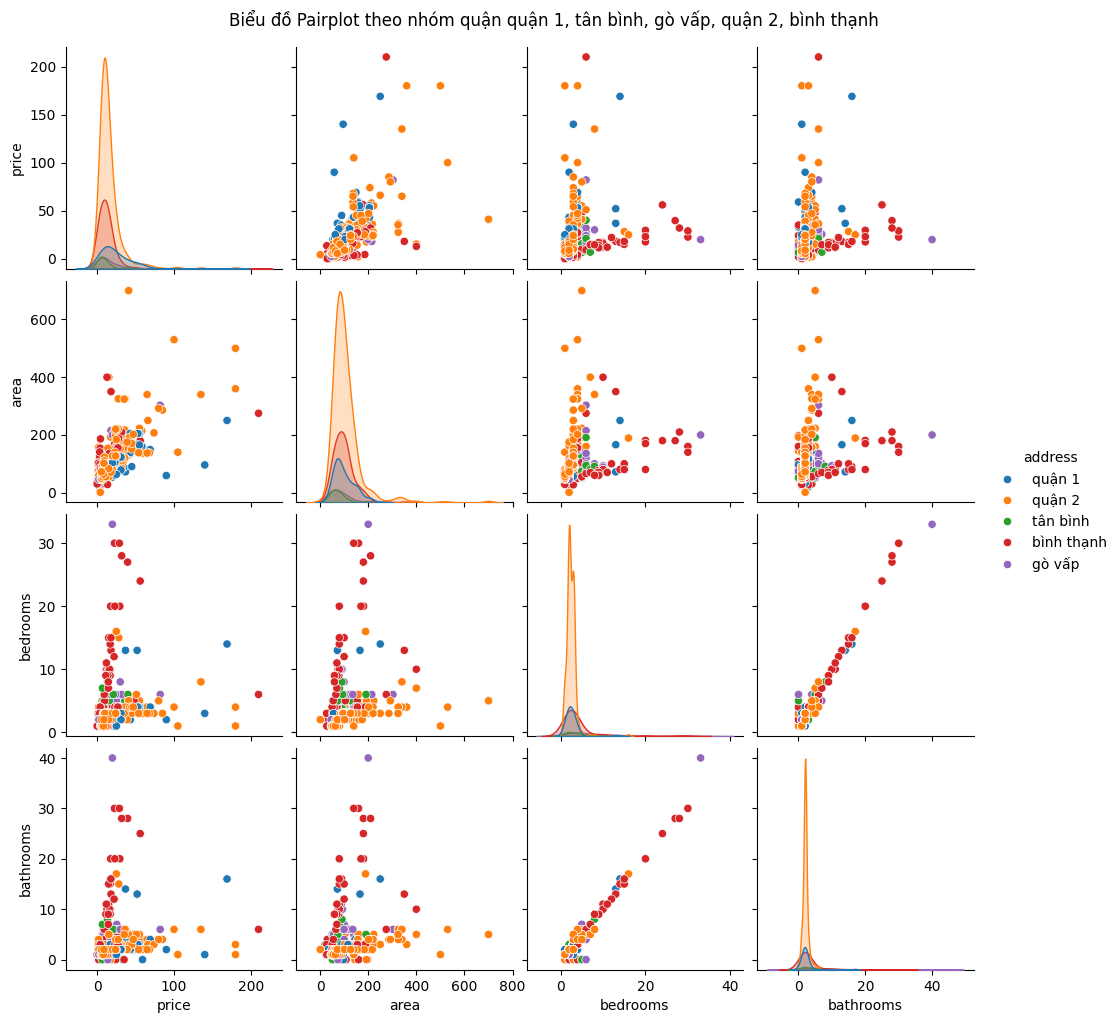

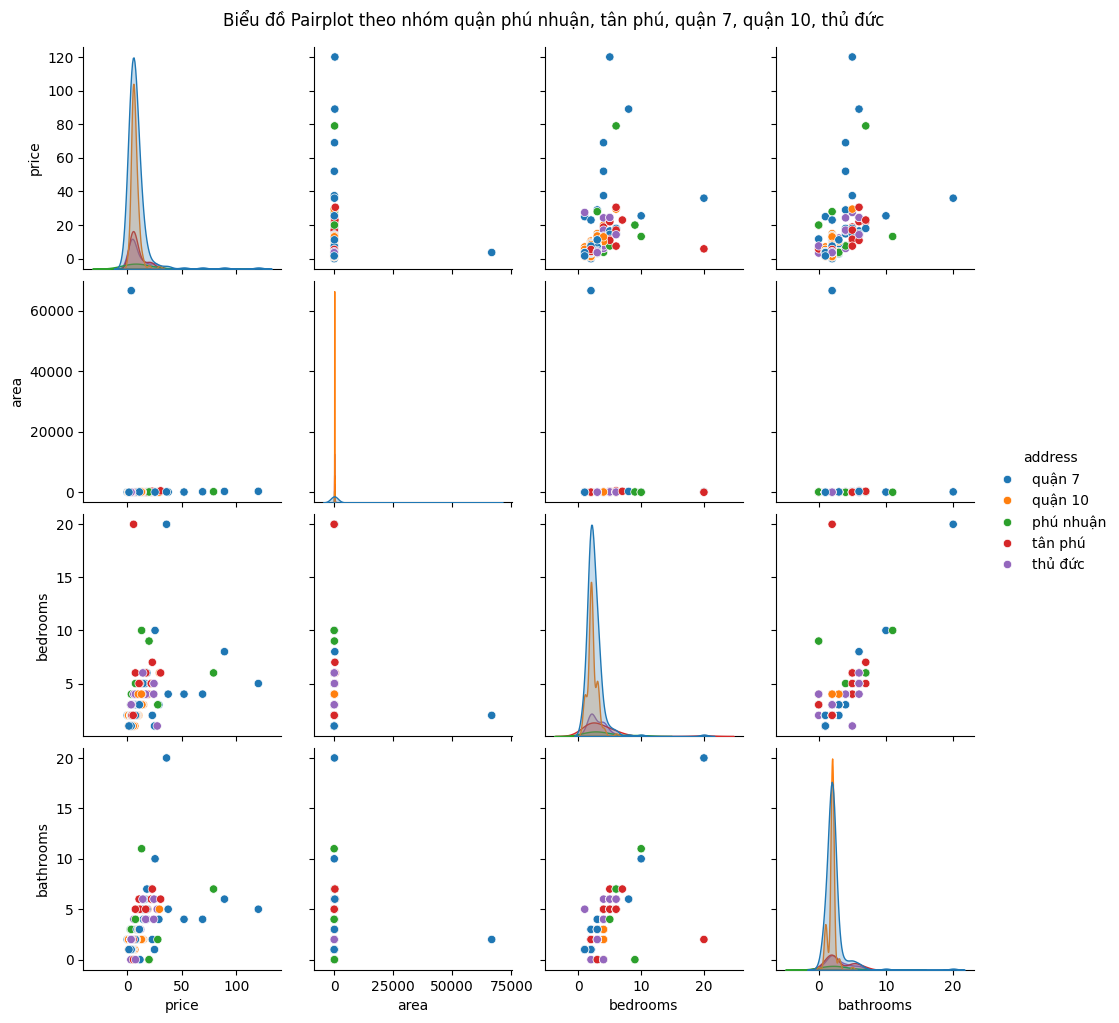

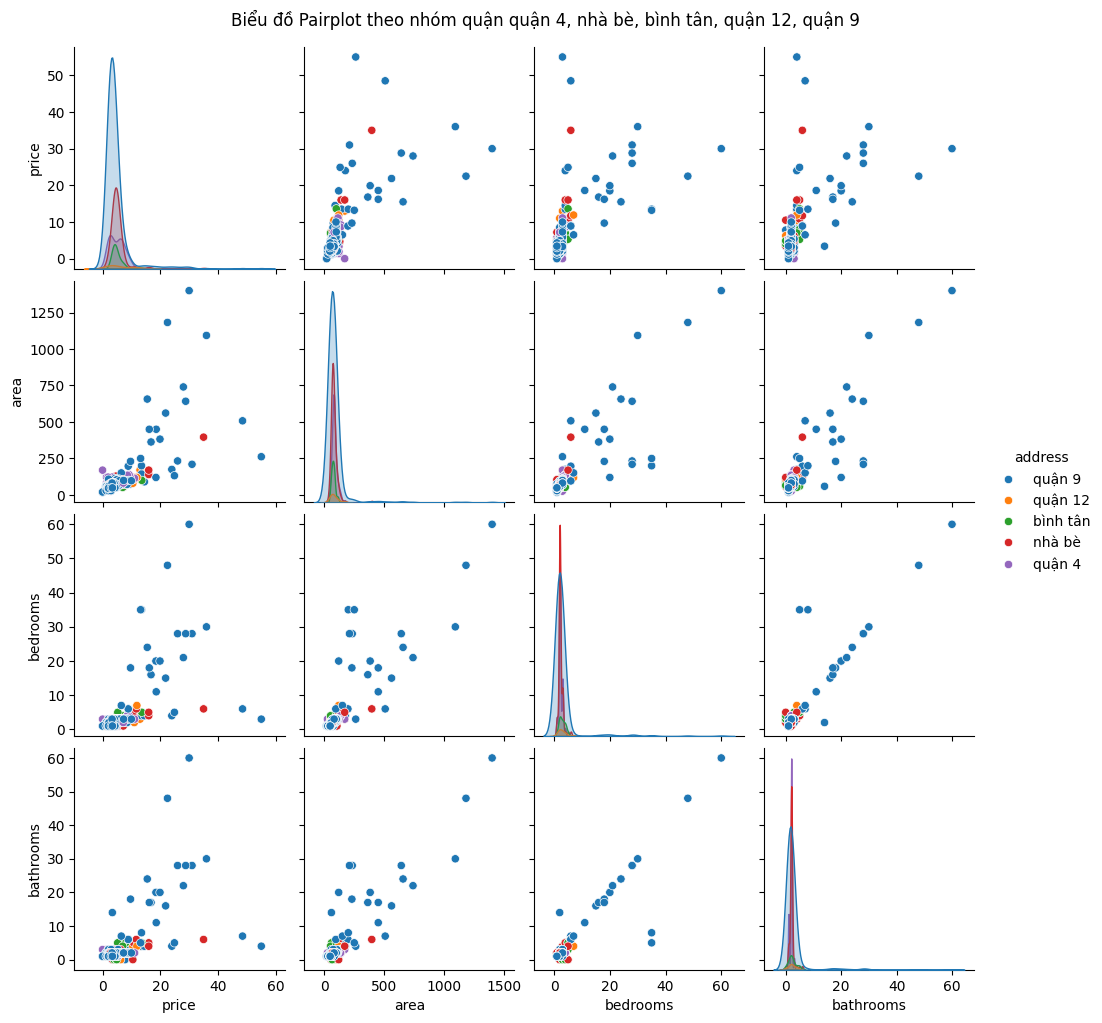

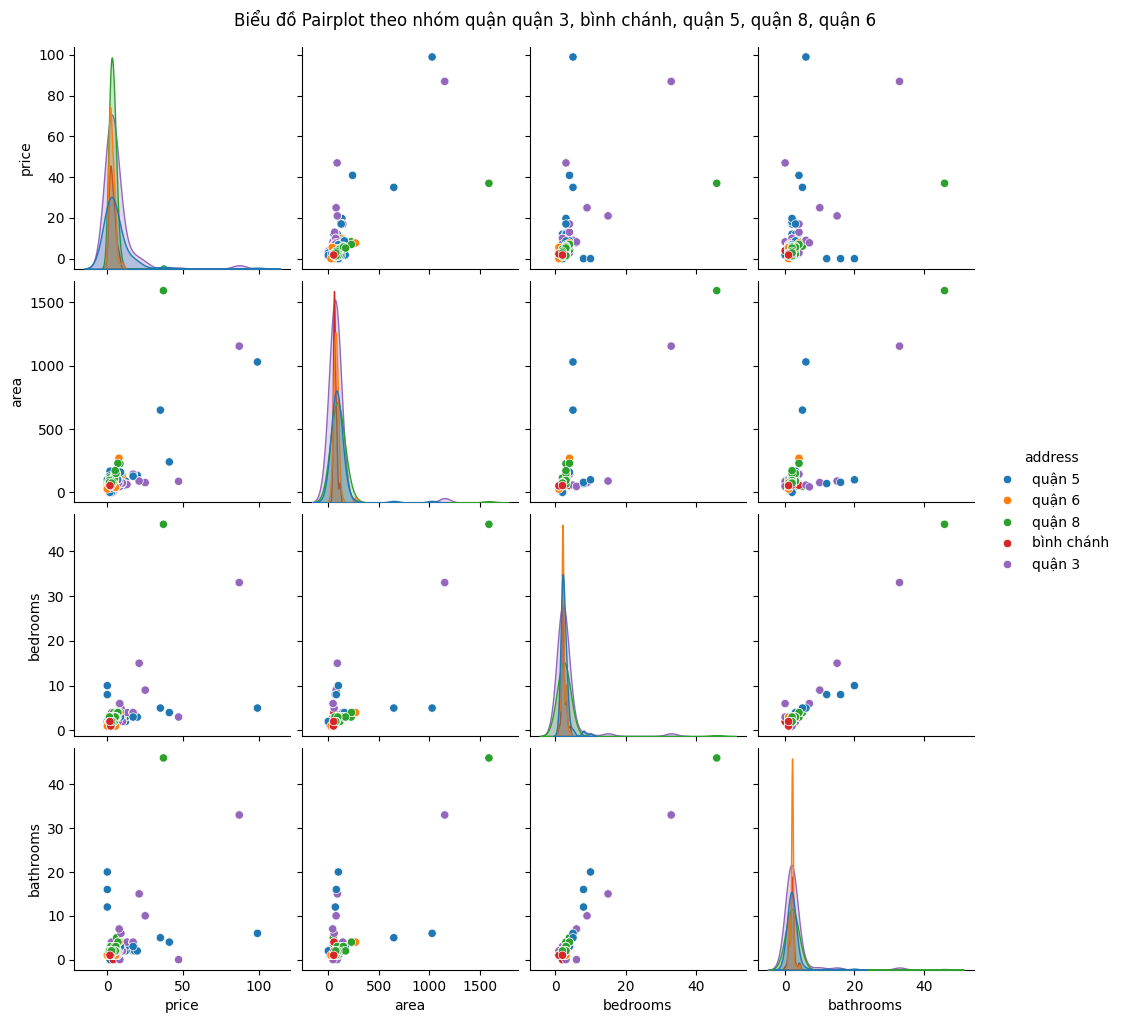

In [40]:
df['price_per_m2'] = df['price'] / df['area']

median_by_address = (
    df.groupby('address')['price_per_m2']
    .median()
    .sort_values(ascending=False)
    .reset_index()
)
median_by_address.columns = ['address', 'median_price_per_m2']
display(median_by_address)

addresses = median_by_address['address'].tolist()

for i in range(0, len(addresses), 5):
    group = addresses[i:i+5]
    df_group = df[df['address'].isin(group)]

    sns.pairplot(
        df_group,
        vars=['price', 'area', 'bedrooms', 'bathrooms'],
        hue='address',
        palette='tab10'
    )
    plt.suptitle(f"Biểu đồ Pairplot theo nhóm quận {', '.join(group)}", y=1.02)
    plt.show()

Sau khi chia dữ liệu theo từng nhóm **5 quận** và vẽ pairplot:

- **Mối quan hệ giữa `area` và các biến khác** (`price`, `bedrooms`, `bathrooms`) gần như **tuyến tính** trong từng quận.  
  - Điều này cho thấy **giá nhà và số phòng/tầng tăng theo diện tích** khá ổn định trong mỗi quận.

- **Sự phân bố giữa các nhóm quận** rất rõ rệt:  
  - Các quận có **giá trung vị/m² cao** như `Quận 1`, `Quận 2`, `Bình Thạnh` tập trung ở **vùng giá và diện tích cao**.  
  - Các quận giá thấp hơn như `Quận 3`, `Quận 6`, `Quận 8` tập trung ở **vùng giá và diện tích thấp hơn**.  
  - Các giá trị cực đại của từng khu vực cũng thường tập trung, cho thấy giá cả **giao động theo đặc trưng khu vực**.

**Kết luận:**  
- Dữ liệu thể hiện **mối quan hệ tuyến tính giữa diện tích và các biến khác** (`price`, `bedrooms`, `bathrooms`) trong từng quận.  
- **Sự khác biệt rõ rệt giữa các quận** chứng tỏ việc **xếp nhóm theo khu vực** là hợp lý khi phân tích và xây dựng mô hình dự đoán giá nhà.


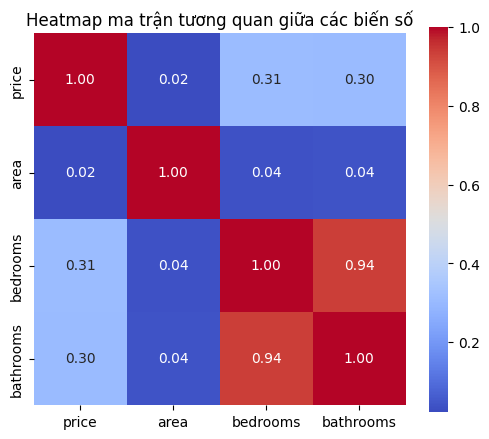

In [41]:
num_cols = ['price', 'area', 'bedrooms', 'bathrooms']
corr_matrix = df_filtered[num_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True,
    square=True
)
plt.title("Heatmap ma trận tương quan giữa các biến số")
plt.show()



Heatmap ma trận tương quan giữa các biến số cho thấy:
- Mức tương quan giữa `bathroom` và `bedrooms` cực kì cao, trong việc xây dựng model, có thể suy xét về việc bỏ 1 trong 2.
- Ngoài ra, **các biến số khác có xu hướng độc lập với nhau**, không ảnh hưởng mạnh lẫn nhau. Điều này sẽ giúp mô hình học được **mối quan hệ riêng biệt giữa mỗi biến và giá nhà** mà không bị nhiễu từ các biến còn lại.

# 4. TÁCH DỮ LIỆU

Để thuận tiện cho việc xây dựng mô hình và đánh giá hiệu quả, dữ liệu được chia thành hai phần:

- **Training set:** `split/train/train.csv`  
- **Testing set:** `split/test/test.csv`


In [43]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_train.to_csv("../data/split/train/train.csv", index=False)
df_test.to_csv("../data/split/test/test.csv", index=False)